<a href="https://colab.research.google.com/github/makonhakony/books-recommendation/blob/main/Copy_of_fcc_book_recommendation_knn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import libraries (you may add additional imports but you may not have to)
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

In [2]:
# get data files
!wget https://cdn.freecodecamp.org/project-data/books/book-crossings.zip

!unzip book-crossings.zip

books_filename = 'BX-Books.csv'
ratings_filename = 'BX-Book-Ratings.csv'

--2023-09-19 18:27:09--  https://cdn.freecodecamp.org/project-data/books/book-crossings.zip
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 172.67.70.149, 104.26.2.33, 104.26.3.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|172.67.70.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26085508 (25M) [application/zip]
Saving to: ‘book-crossings.zip’

book-crossings.zip  100%[===================>]  24.88M  60.3MB/s    in 0.4s    

2023-09-19 18:27:10 (60.3 MB/s) - ‘book-crossings.zip’ saved [26085508/26085508]

Archive:  book-crossings.zip
  inflating: BX-Book-Ratings.csv     
  inflating: BX-Books.csv            
  inflating: BX-Users.csv            


In [3]:
# import csv data into dataframes
df_books = pd.read_csv(
    books_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['isbn', 'title', 'author'],
    usecols=['isbn', 'title', 'author'],
    dtype={'isbn': 'str', 'title': 'str', 'author': 'str'})

df_ratings = pd.read_csv(
    ratings_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['user', 'isbn', 'rating'],
    usecols=['user', 'isbn', 'rating'],
    dtype={'user': 'int32', 'isbn': 'str', 'rating': 'float32'})

# Investigating Data

In [4]:
# add your code here - consider creating a new cell for each section of code
df_books.head(10)

,isbn,title,author
0,0195153448,Classical Mythology,Mark P. O. Morford
1,0002005018,Clara Callan,Richard Bruce Wright
2,0060973129,Decision in Normandy,Carlo D'Este
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata
4,0393045218,The Mummies of Urumchi,E. J. W. Barber
5,0399135782,The Kitchen God's Wife,Amy Tan
6,0425176428,What If?: The World's Foremost Military Histor...,Robert Cowley
7,0671870432,PLEADING GUILTY,Scott Turow
8,0679425608,Under the Black Flag: The Romance and the Real...,David Cordingly
9,074322678X,Where You'll Find Me: And Other Stories,Ann Beattie


In [5]:
df_ratings.head(10)

,user,isbn,rating
0,276725,034545104X,0.0
1,276726,0155061224,5.0
2,276727,0446520802,0.0
3,276729,052165615X,3.0
4,276729,0521795028,6.0
5,276733,2080674722,0.0
6,276736,3257224281,8.0
7,276737,0600570967,6.0
8,276744,038550120X,7.0
9,276745,342310538,10.0


In [6]:
df_books['isbn'].is_unique

True

In [7]:
df_ratings['isbn'].is_unique

False

In [8]:
# Set the index of df_books to 'isbn'
df_books.set_index('isbn', inplace=True)

# Join df_ratings and df_books on 'isbn'
df_joined = df_ratings.join(df_books, on='isbn')


In [9]:
df_joined.head(10)

,user,isbn,rating,title,author
0,276725,034545104X,0.0,Flesh Tones: A Novel,M. J. Rose
1,276726,0155061224,5.0,Rites of Passage,Judith Rae
2,276727,0446520802,0.0,The Notebook,Nicholas Sparks
3,276729,052165615X,3.0,Help!: Level 1,Philip Prowse
4,276729,0521795028,6.0,The Amsterdam Connection : Level 4 (Cambridge ...,Sue Leather
5,276733,2080674722,0.0,Les Particules Elementaires,Michel Houellebecq
6,276736,3257224281,8.0,NaN,NaN
7,276737,0600570967,6.0,NaN,NaN
8,276744,038550120X,7.0,A Painted House,JOHN GRISHAM
9,276745,342310538,10.0,NaN,NaN


In [33]:
df_joined.dropna(subset=['isbn'], inplace=True)

df_joined.dropna(subset=['title'], inplace=True)

df_joined.dropna(subset=['author'], inplace=True)

df_joined['train_text'] = df_joined['title']  + " "+ df_joined['user'].astype(str) + " "+ df_joined['rating'].astype(str)

df_joined.head(10)

,user,isbn,rating,title,author,train_text
0,276725,034545104X,0.0,Flesh Tones: A Novel,M. J. Rose,Flesh Tones: A Novel 276725 0.0
1,276726,0155061224,5.0,Rites of Passage,Judith Rae,Rites of Passage 276726 5.0
2,276727,0446520802,0.0,The Notebook,Nicholas Sparks,The Notebook 276727 0.0
3,276729,052165615X,3.0,Help!: Level 1,Philip Prowse,Help!: Level 1 276729 3.0
4,276729,0521795028,6.0,The Amsterdam Connection : Level 4 (Cambridge ...,Sue Leather,The Amsterdam Connection : Level 4 (Cambridge ...
5,276733,2080674722,0.0,Les Particules Elementaires,Michel Houellebecq,Les Particules Elementaires 276733 0.0
8,276744,038550120X,7.0,A Painted House,JOHN GRISHAM,A Painted House 276744 7.0
10,276746,0425115801,0.0,Lightning,Dean R. Koontz,Lightning 276746 0.0
11,276746,0449006522,0.0,Manhattan Hunt Club,JOHN SAUL,Manhattan Hunt Club 276746 0.0
12,276746,0553561618,0.0,Dark Paradise,TAMI HOAG,Dark Paradise 276746 0.0


Check Passed Condition Data

In [34]:
df_books[df_books['title'] == "Where the Heart Is (Oprah's Book Club (Paperback))"]

,title,author
isbn,,
0446672211,Where the Heart Is (Oprah's Book Club (Paperba...,Billie Letts


In [35]:
df_books[df_books['title'] == "I'll Be Seeing You"]

,title,author
isbn,,
0671888587,I'll Be Seeing You,Mary Higgins Clark
0553567187,I'll Be Seeing You,LURLENE MCDANIEL


In [36]:
df_books[df_books['title'] == "The Weight of Water"]

,title,author
isbn,,
0316782505,The Weight of Water,Anita Shreve


In [37]:
df_books[df_books['title'] == "The Surgeon"]

,title,author
isbn,,
0345447840,The Surgeon,TESS GERRITSEN
0345447832,The Surgeon,TESS GERRITSEN
0451180240,The Surgeon,Francis Roe
0749902698,The Surgeon,Francis Roe


In [38]:
df_books[df_books['title'] == "I Know This Much Is True"]

,title,author
isbn,,
0060987561,I Know This Much Is True,Wally Lamb
0061097640,I Know This Much Is True,Wally Lamb
0965605914,I Know This Much Is True,Wally Lamb
0694519405,I Know This Much Is True,Wally Lamb


If you graph the dataset (optional), you will notice that most books are not rated frequently. To ensure statistical significance, remove from the dataset users with less than 200 ratings and books with less than 100 ratings.

<Axes: title={'center': 'title'}, xlabel='Number of reviews per book', ylabel='Frequency of a review'>

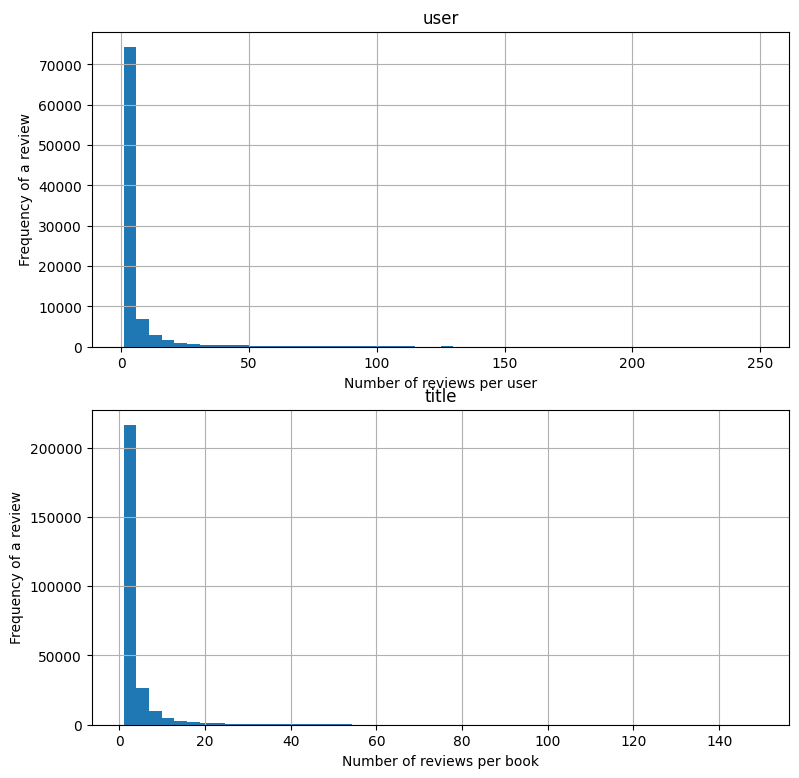

In [39]:
# Plotting the dataset for exploratory analysis
fig, axes = plt.subplots(2, 1, figsize=(9, 9))
axes[0].set_title("user")
axes[0].set_xlabel("Number of reviews per user")
axes[0].set_ylabel("Frequency of a review")
axes[1].set_title("title")
axes[1].set_xlabel("Number of reviews per book")
axes[1].set_ylabel("Frequency of a review")
user_unique= df_joined["user"].value_counts()
user_unique[user_unique<250].hist(bins=50, ax = axes[0])
isbn_unique= df_joined["isbn"].value_counts()
isbn_unique[isbn_unique<150].hist(bins=50, ax = axes[1])

# Preprocessing Data

In [ ]:
#df_books = df_books.groupby('user').filter(lambda x: len(x) >= 200)

In [40]:
# Selecting indices of books with more than 100 reviews and users with more than
# 200 reviews.
user_unique = user_unique[user_unique >= 200].index
isbn_unique = isbn_unique[isbn_unique >= 100].index

In [63]:
df_filter = df_joined.loc[(df_joined["user"].isin(user_unique.values)) & (df_joined["isbn"].isin(isbn_unique.values))]
df_filter = df_filter.drop_duplicates(['title', 'user'])


In [64]:
df_para = df_filter.pivot(index = 'title', columns = 'user', values = 'rating').fillna(0)
df_para.head(10)

user,254,2276,2766,2977,3363,4017,4385,6251,6323,6543,...,271705,273979,274004,274061,274301,274308,275970,277427,277639,278418
title,,,,,,,,,,,,,,,,,,,,,
1984,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1st to Die: A Novel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2nd Chance,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4 Blondes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A Beautiful Mind: The Life of Mathematical Genius and Nobel Laureate John Nash,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A Bend in the Road,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A Case of Need,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"A Child Called \It\"": One Child's Courage to Survive""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A Civil Action,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [65]:
df_matrix = csr_matrix(df_para.values)

# Training Data

In [88]:
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import TfidfVectorizer


# Create a TfidfVectorizer object
#tfidf = TfidfVectorizer(stop_words='english')

# Fit and transform the 'title' column of df_books
#tfidf_matrix = tfidf.fit_transform(df_filter['train_text'])

# Create a NearestNeighbors object
nn = NearestNeighbors(n_neighbors=5, metric='cosine')
nn.fit(df_matrix)

NearestNeighbors(metric='cosine')

In [92]:
# function to return recommended books - this will be tested
def get_recommends(book = ""):
  global df_para, nn
  result = [book,[]]

  distances, indices = nn.kneighbors([df_para.loc[book]])

  recom_str = df_para.iloc[np.flip(indices[0])[:-1]].index.to_list()
  recom_dist = list(np.flip(distances[0])[:-1])
  for r in zip(recom_str,recom_dist):
    result[1].append(list(r))


  return result

In [95]:
get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))")

["Where the Heart Is (Oprah's Book Club (Paperback))",
 [['The Weight of Water', 0.7678344],
  ['The Surgeon', 0.76690507],
  ['I Know This Much Is True', 0.764642],
  ['The Lovely Bones: A Novel', 0.7158567]]]

In [96]:
books = get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))")
print(books)

def test_book_recommendation():
  test_pass = True
  recommends = get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))")
  if recommends[0] != "Where the Heart Is (Oprah's Book Club (Paperback))":
    test_pass = False
  recommended_books = ["I'll Be Seeing You", 'The Weight of Water', 'The Surgeon', 'I Know This Much Is True']
  recommended_books_dist = [0.8, 0.77, 0.77, 0.77]
  for i in range(2):
    if recommends[1][i][0] not in recommended_books:
      test_pass = False
    if abs(recommends[1][i][1] - recommended_books_dist[i]) >= 0.05:
      test_pass = False
  if test_pass:
    print("You passed the challenge! 🎉🎉🎉🎉🎉")
  else:
    print("You haven't passed yet. Keep trying!")

test_book_recommendation()

["Where the Heart Is (Oprah's Book Club (Paperback))", [['The Weight of Water', 0.7678344], ['The Surgeon', 0.76690507], ['I Know This Much Is True', 0.764642], ['The Lovely Bones: A Novel', 0.7158567]]]
You passed the challenge! 🎉🎉🎉🎉🎉
